# 1 - Introduction

Dataset: Financial phrase bank. Collection of thousands of headline news related to finance, curated by 16 individuals with relevant background.

link: https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip

# 2 - Importing Libraries

In [21]:
import re, random, string, nltk, os
import tensorflow as tf


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #; sns.set()
#plt.style.use('ggplot')

#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Input, Embedding, Dense, Dropout, LSTM, GRU, GlobalAveragePooling1D, TextVectorization, Conv1D
from tensorflow.keras.utils import to_categorical

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import defaultdict, Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
# Set Random Seed
random.seed(69)
np.random.seed(69)
rand_seed = 69

# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

# 3 - Data Loading

In [23]:
filename = 'Sentences_75Agree.txt'
data = pd.read_csv(filename, encoding='unicode_escape', sep='\@', engine='python', header=None, names=['sentence','label'])
print('Total number of record in the file: ', data.shape[0])
data.drop_duplicates(inplace=True)
print('Total number of record after dropping duplicates: ', data.shape[0])
print('Missing label: ', data['label'].isnull().sum())
data.reset_index(inplace=True, drop=True)

Total number of record in the file:  3453
Total number of record after dropping duplicates:  3448
Missing label:  0


In [24]:
# Samples
pd.set_option('display.max_colwidth', None)
data.sample(n=5, random_state=42)

,sentence,label
2900,"The period-end cash and cash equivalents totaled EUR6 .5 m , compared to EUR10 .5 m in the previous year .",negative
51,"In June it sold a 30 percent stake to Nordstjernan , and the investment group has now taken up the option to acquire EQT 's remaining shares .",neutral
567,The aim is an annual improvement in Ruukki Construction 's operating profit of more than EUR 3 million USD 4.1 m starting in 2009 .,positive
3268,"Sampo Bank 's market share of lending was 13.6 % , down from 14.4 % in the first quarter of 2008 .",negative
1987,"In 2008 , the steel industry accounted for 64 percent of the cargo volumes transported , whereas the energy industry accounted for 28 percent and other industries for 8 percent .",neutral


# 4 - EDA

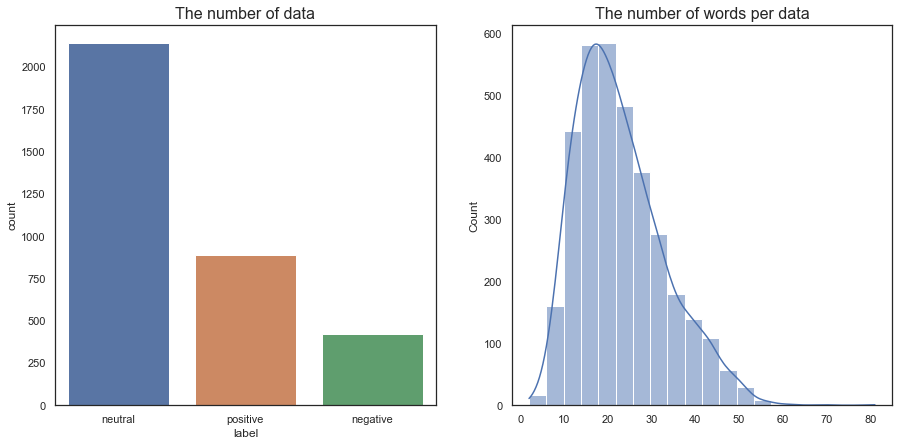

In [25]:
# visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='label', data=data, ax=ax1)
ax1.set_title('The number of data', fontsize=16)
sns.histplot([len(nltk.word_tokenize(words)) for words in data['sentence']], bins=20, ax=ax2, kde=True)
ax2.set_title('The number of words per data', fontsize=16)
plt.show()

More than 60% of the data are labeled as "neutral". In most cases, we can just balance the data by using resampling methods such as SMOTE. But they are methods for numerical data.

In addition, this imbalance should be also taken into consideration if this happends in the real world. In this case, this can be interpreted as the result of the nature of news, so decided not to resample the data.

In [26]:
# Encode the label
le = LabelEncoder()
le.fit(data['label'])
print(list(le.classes_))
data['label'] = le.transform(data['label'])
data['label'].head()

['negative', 'neutral', 'positive']


0    1
1    2
2    2
3    2
4    2
Name: label, dtype: int32

In [27]:
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stopwords(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        stop = set(stopwords.words('english'))
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_non_stopwords(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        stop = set(stopwords.words('english'))
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [28]:
corpus = create_corpus(data)
x, y = get_frequent_stopwords(corpus)
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'is', 'from', 'will')
(4257, 2311, 2086, 1792, 1706, 1169, 842, 634, 632, 557)


Above are the frequently appeared words including stop words.

In [29]:
x, y = get_frequent_non_stopwords(corpus)
print(x)
print(y)

('.', ',', 'eur', "'s", 'company', 'mn', 'profit', ')', 'net', '(')
(3389, 3277, 916, 698, 574, 500, 385, 381, 378, 378)


Above are the frequently appeared words excluding stop words.

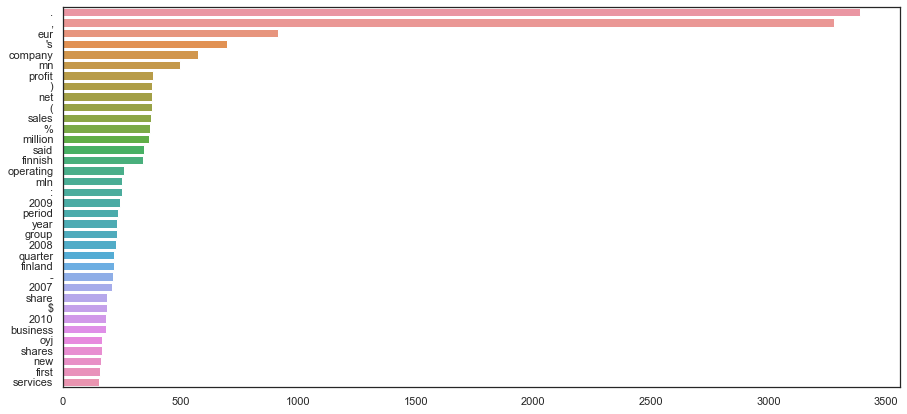

In [30]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    # stop = set(stopwords.words('english'))
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x);

Apparently, the most frequent word/character is period.

## Word Cloud

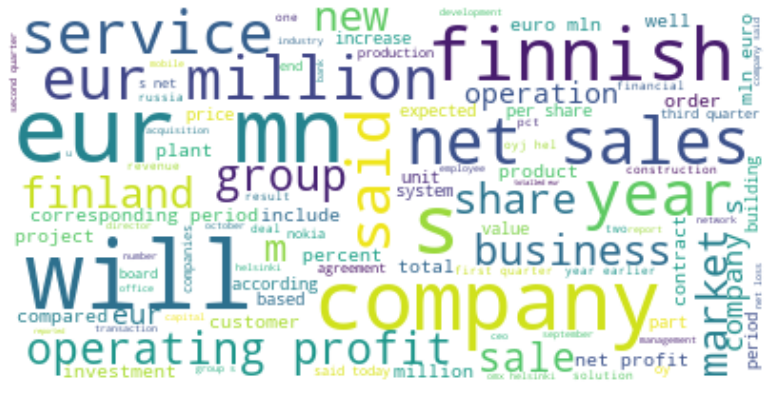

In [31]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# 5 - Data Preprocessing

Downcasing, removing punctuation, removing stopwords, removing numbers, lemmatizing.

In [32]:
# convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() # lower case
    text = text.strip()  # remove leading and trailing spaces
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) # remove punctuations  
    text = re.sub('\s+', ' ', text) # remove extra spaces 
    text = re.sub(r'[^\w\s]', ' ', str(text).lower().strip()) # remove special characters
    text = re.sub(r'\d',' ',text) # remove digits
    
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# LEMMATIZATION
wl = WordNetLemmatizer()
 
# Helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [33]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [34]:
from nltk.corpus import stopwords, wordnet

In [35]:
data['clean_sentence'] = data['sentence'].apply(lambda x: finalpreprocess(x))

In [36]:
data.head()

,sentence,label,clean_sentence
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",1,accord gran company plan move production russia although company grow
1,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,2,new production plant company would increase capacity meet expect increase demand would improve use raw material therefore increase production profitability
2,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",2,last quarter componenta net sale double eur eur period year earlier move zero pre tax profit pre tax loss eur
3,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",2,third quarter net sale increase eur mn operating profit eur mn
4,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,2,operating profit rise eur mn eur mn correspond period represent net sale


Split the data into training, test and val sets.

In [37]:
# Split the data into training and test set

X_train, X_test, y_train, y_test = train_test_split(data['clean_sentence'], data['label'], test_size=0.2, random_state=69, stratify=data['label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=69, stratify=y_train)

In [38]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('')
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('')
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (2730,)
y_train shape:  (2730,)

X_test shape:  (690,)
y_test shape:  (690,)

X_val shape:  (28,)
y_val shape:  (28,)


* train set = training
* test set = testing/validation
* val set = inference

Tokenization

In [39]:
round(sum([len(i.split()) for i in X_train]) / len(X_train))

12

In [40]:
max_vocab_length = 9000
max_length = 12

In [41]:
# setup vect
text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_length,
                                       input_shape=(1,) 
                                       )

In [42]:
text_vectorization.adapt(X_train)

In [43]:
# Embedding layer
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length, name='Sentence-Embedding')

prep target/label

In [44]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

# 6 - Model Definition

## Model 1

In [45]:
model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model 2

In [46]:
model2 = Sequential()
model2.add(text_vectorization)
model2.add(embedding)
model2.add(LSTM(4))
model2.add(Dropout(0.4))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation='softmax'))

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model 3

In [47]:
model3 = Sequential()
model3.add(text_vectorization)
model3.add(embedding)
model3.add(GRU(4))
model3.add(Dropout(0.4))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 7 - Model Training

In [48]:
num_epoch = 50
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # early stopping set after 5 epochs

## Model 1

In [49]:
model_1_hist = model.fit(x = X_train,
                         y = y_train_ohe,
                         epochs=num_epoch, callbacks=[stop_early],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
86/86 [==============================] - 2s 13ms/step - loss: 0.8986 - accuracy: 0.6245 - val_loss: 0.6729 - val_accuracy: 0.7159
Epoch 2/50
86/86 [==============================] - 1s 9ms/step - loss: 0.5402 - accuracy: 0.7711 - val_loss: 0.5542 - val_accuracy: 0.7681
Epoch 3/50
86/86 [==============================] - 1s 9ms/step - loss: 0.3396 - accuracy: 0.8388 - val_loss: 0.5454 - val_accuracy: 0.7884
Epoch 4/50
86/86 [==============================] - 1s 10ms/step - loss: 0.2036 - accuracy: 0.9337 - val_loss: 0.5647 - val_accuracy: 0.8145
Epoch 5/50
86/86 [==============================] - 1s 9ms/step - loss: 0.1161 - accuracy: 0.9637 - val_loss: 0.6248 - val_accuracy: 0.8087
Epoch 6/50
86/86 [==============================] - 1s 9ms/step - loss: 0.0794 - accuracy: 0.9766 - val_loss: 0.6846 - val_accuracy: 0.8101
Epoch 7/50
86/86 [==============================] - 1s 9ms/step - loss: 0.0611 - accuracy: 0.9824 - val_loss: 0.7394 - val_accuracy: 0.8014
Epoch 8/50
86/86 [

## Model 2

In [50]:
model_2_hist = model2.fit(x = X_train,
                         y = y_train_ohe,
                         epochs=num_epoch, callbacks=[stop_early],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
86/86 [==============================] - 4s 21ms/step - loss: 0.7050 - accuracy: 0.6784 - val_loss: 0.7157 - val_accuracy: 0.7101
Epoch 2/50
86/86 [==============================] - 1s 14ms/step - loss: 0.5062 - accuracy: 0.7886 - val_loss: 0.6943 - val_accuracy: 0.7406
Epoch 3/50
86/86 [==============================] - 1s 14ms/step - loss: 0.3972 - accuracy: 0.8381 - val_loss: 0.7118 - val_accuracy: 0.7565
Epoch 4/50
86/86 [==============================] - 1s 14ms/step - loss: 0.3221 - accuracy: 0.8648 - val_loss: 1.0636 - val_accuracy: 0.7754
Epoch 5/50
86/86 [==============================] - 1s 14ms/step - loss: 0.2803 - accuracy: 0.8846 - val_loss: 0.9581 - val_accuracy: 0.7551
Epoch 6/50
86/86 [==============================] - 1s 14ms/step - loss: 0.2766 - accuracy: 0.8846 - val_loss: 1.0453 - val_accuracy: 0.7942
Epoch 7/50
86/86 [==============================] - 1s 14ms/step - loss: 0.2405 - accuracy: 0.9066 - val_loss: 1.1101 - val_accuracy: 0.7812


## Model 3

In [51]:
model_3_hist = model3.fit(x = X_train,
                         y = y_train_ohe,
                         epochs=num_epoch, callbacks=[stop_early],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
86/86 [==============================] - 4s 22ms/step - loss: 0.5547 - accuracy: 0.7791 - val_loss: 0.9065 - val_accuracy: 0.7014
Epoch 2/50
86/86 [==============================] - 1s 16ms/step - loss: 0.3862 - accuracy: 0.8355 - val_loss: 0.9375 - val_accuracy: 0.7449
Epoch 3/50
86/86 [==============================] - 1s 17ms/step - loss: 0.3198 - accuracy: 0.8579 - val_loss: 1.1092 - val_accuracy: 0.7464
Epoch 4/50
86/86 [==============================] - 1s 16ms/step - loss: 0.3131 - accuracy: 0.8564 - val_loss: 1.1507 - val_accuracy: 0.7420
Epoch 5/50
86/86 [==============================] - 1s 16ms/step - loss: 0.2822 - accuracy: 0.8788 - val_loss: 1.1452 - val_accuracy: 0.7536
Epoch 6/50
86/86 [==============================] - 1s 17ms/step - loss: 0.2596 - accuracy: 0.8883 - val_loss: 1.3652 - val_accuracy: 0.7290


# 8 - Model Evaluation

## Model 1

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [53]:
metrics = pd.DataFrame(model_1_hist.history)
metrics[['loss', 'val_loss']].plot();

In [54]:
y_pred_1 = model.predict(X_test)
y_pred_1 = y_pred_1.argmax(axis=1)
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.34      0.18      0.23        84
           1       0.70      0.97      0.81       428
           2       0.73      0.21      0.33       178

    accuracy                           0.68       690
   macro avg       0.59      0.45      0.46       690
weighted avg       0.66      0.68      0.62       690



## Model 2

In [55]:
tf.keras.utils.plot_model(model2, show_shapes=True)
# model2.summary()

In [56]:
metrics = pd.DataFrame(model_2_hist.history)
metrics[['loss', 'val_loss']].plot();

In [57]:
y_pred_2 = model2.predict(X_test)
y_pred_2 = y_pred_2.argmax(axis=1)
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.60      0.51      0.55        84
           1       0.84      0.87      0.86       428
           2       0.63      0.62      0.63       178

    accuracy                           0.76       690
   macro avg       0.69      0.67      0.68       690
weighted avg       0.76      0.76      0.76       690



## Model 3

In [58]:
metrics = pd.DataFrame(model_2_hist.history)
metrics[['loss', 'val_loss']].plot();

In [59]:
y_pred_3 = model3.predict(X_test)
y_pred_3 = y_pred_3.argmax(axis=1)
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.37      0.50      0.42        84
           1       0.85      0.84      0.84       428
           2       0.67      0.57      0.62       178

    accuracy                           0.73       690
   macro avg       0.63      0.64      0.63       690
weighted avg       0.74      0.73      0.73       690



## Comparison

In [60]:
print('Model 1 f1-score: {}'.format(np.around(f1_score(y_test, y_pred_1, average=None), decimals=3)))
print('Model 2 f1-score: {}'.format(np.around(f1_score(y_test, y_pred_2, average=None), decimals=3)))
print('Model 3 f1-score: {}'.format(np.around(f1_score(y_test, y_pred_3, average=None), decimals=3)))

Model 1 f1-score: [0.234 0.81  0.33 ]
Model 2 f1-score: [0.551 0.857 0.627]
Model 3 f1-score: [0.422 0.845 0.616]


In [61]:
print('Model 1 weighted f1-score: {}'.format(np.around(f1_score(y_test, y_pred_1, average='weighted'), decimals=3)))
print('Model 2 weighted f1-score: {}'.format(np.around(f1_score(y_test, y_pred_2, average='weighted'), decimals=3)))
print('Model 3 weighted f1-score: {}'.format(np.around(f1_score(y_test, y_pred_3, average='weighted'), decimals=3)))

Model 1 weighted f1-score: 0.616
Model 2 weighted f1-score: 0.761
Model 3 weighted f1-score: 0.734


## 8.1 - New methods (using Keras tokenizer, pad sequences, pre-trained word embedding GloVe, Conv1D, and GlobalAveragePooling1D)

In [62]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1

In [63]:
# save tokenizer
#import pickle
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle)

In [64]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_tokenized, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_tokenized, maxlen=100, padding='post')
X_val_pad = pad_sequences(X_val_tokenized, maxlen=100, padding='post')

In [65]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [66]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

In [67]:
modeltry = Sequential()
modeltry.add
modeltry.add(Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=100, 
                           trainable=True))
modeltry.add(Conv1D(128, 5, activation='relu'))
modeltry.add(GlobalAveragePooling1D())
modeltry.add(Dense(16, activation='relu'))
modeltry.add(Dense(3, activation='softmax'))
modeltry.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [68]:
modeltry_hist = modeltry.fit(x = X_train_pad,
                         y = y_train_ohe,
                         epochs=num_epoch, callbacks=[stop_early],
                         validation_data=(X_val_pad, y_val_ohe), batch_size=64)

Epoch 1/50
43/43 [==============================] - 1s 21ms/step - loss: 0.9370 - accuracy: 0.6088 - val_loss: 0.8435 - val_accuracy: 0.6429
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 0.7724 - accuracy: 0.6875 - val_loss: 0.7450 - val_accuracy: 0.6786
Epoch 3/50
43/43 [==============================] - 1s 14ms/step - loss: 0.6959 - accuracy: 0.7062 - val_loss: 0.6782 - val_accuracy: 0.6786
Epoch 4/50
43/43 [==============================] - 1s 14ms/step - loss: 0.6299 - accuracy: 0.7300 - val_loss: 0.6010 - val_accuracy: 0.7143
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 0.5765 - accuracy: 0.7476 - val_loss: 0.5586 - val_accuracy: 0.7500
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 0.5192 - accuracy: 0.7678 - val_loss: 0.5200 - val_accuracy: 0.7143
Epoch 7/50
43/43 [==============================] - 1s 14ms/step - loss: 0.4692 - accuracy: 0.7912 - val_loss: 0.5043 - val_accuracy: 0.7143
Epoch 8/50
43

In [69]:
y_predtry = modeltry.predict(X_test_pad)
y_predtry = y_predtry.argmax(axis=1)
print(classification_report(y_test, y_predtry))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67        84
           1       0.87      0.95      0.91       428
           2       0.83      0.76      0.79       178

    accuracy                           0.86       690
   macro avg       0.84      0.76      0.79       690
weighted avg       0.85      0.86      0.85       690



In [70]:
print('Model 1 weighted f1-score: {}'.format(np.around(f1_score(y_test, y_pred_1, average='weighted'), decimals=3)))
print('Model 2 weighted f1-score: {}'.format(np.around(f1_score(y_test, y_pred_2, average='weighted'), decimals=3)))
print('Model 3 weighted f1-score: {}'.format(np.around(f1_score(y_test, y_pred_3, average='weighted'), decimals=3)))
print('Model try weighted f1-score: {}'.format(np.around(f1_score(y_test, y_predtry, average='weighted'), decimals=3)))

Model 1 weighted f1-score: 0.616
Model 2 weighted f1-score: 0.761
Model 3 weighted f1-score: 0.734
Model try weighted f1-score: 0.851


# 9 - Model Saving

Saving the best model

In [71]:
modeltry.save('model_glove_conv1d_gap')

INFO:tensorflow:Assets written to: model_glove_conv1d_gap\assets


# 10 - Model Inference

In [72]:
print(X_val.shape)
X_val.head()

(28,)


1684                                         sullivan say board really involve lot work people get pay time
608                 furthermore efficiency improvement measure initiate earlier bear fruit ceo jan lang say
30                                                     helsinki eliiv today report eps eur increase eps eur
1091                                                                  investment worth approximately eur mn
61      acquisition considerably increase kemira sale market position russian metal industry coating market
Name: clean_sentence, dtype: object

In [73]:
y_val.reset_index(drop=True, inplace=True)

In [75]:
y_pred_inf = modeltry.predict(X_val_pad)
y_pred_inf = y_pred_inf.argmax(axis=1)

In [76]:
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['label-pred'])

In [77]:
print('Model try prediction to new data')
final = pd.concat([y_val, y_pred_inf_df], axis=1)
final.head(30)

Model try prediction to new data


,label,label-pred
0,1,1
1,2,2
2,2,2
3,1,1
4,2,2
5,1,1
6,2,2
7,1,1
8,1,1
9,1,1


Wrong predictions: 4/28. Accuracy achieved: 85.7%